The visualization used for this homework is based on Alexandr Verinov's code.  

# Generative models

In this homework we will try several criterions for learning an implicit model. Almost everything is written for you, and you only need to implement the objective for the game and play around with the model. 

**0)** Read the code

**1)** Implement objective for a vanilla [Generative Adversarial Networks](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (GAN). The hyperparameters are already set in the code. The model will converge if you implement the objective (1) right. 

**2)** Note the discussion in the paper, that the objective for $G$ can be of two kinds: $min_G log(1 - D)$ and $min_G - log(D)$. Implement the second objective and ensure model converges. Most likely, in this example you will not notice the difference, but people usually use the second objective, it really matters in more complicated scenarios.

**3 & 4)** Implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([WGAN](https://arxiv.org/abs/1704.00028)) and WGAN-GP. To make the discriminator have Lipschitz property you need to clip discriminator's weights to $[-0.01, 0.01]$ range (WGAN) or use gradient penalty (WGAN-GP). You will need to make few modifications to the code: 1) remove sigmoids from discriminator 2) add weight clipping clipping / gradient penaly. 3) change objective. See [implementation 1](https://github.com/martinarjovsky/WassersteinGAN/) / [implementation 2](https://github.com/caogang/wgan-gp). They also use different optimizer. The default hyperparameters may not work, spend time to tune them.

**5) Bonus: same thing without GANs** Implement maximum mean discrepancy estimator (MMD). MMD is discrepancy measure between distributions. In our case we use it to calculate discrepancy between real and fake data. You need to implement RBF kernel $k(x,x')=\exp \left(-{\frac  {1}{2\sigma ^{2}}}||x-x'||^{2}\right)$ and an MMD estimator (see eq.8 from https://arxiv.org/pdf/1505.03906.pdf). MMD is then used instead of discriminator.

In [1]:
""" 
    Please, implement everything in one notebook, using if statements to switch between the tasks
"""
TASK = 4 #1, 2, 3, 4, 5

# Imports

In [2]:
import numpy as np
import time
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12345)
lims=(-5, 5)

# Define sampler from real data and Z 

In [3]:
from scipy.stats import rv_discrete

MEANS = np.array(
        [[-1,-3],
         [1,3],
         [-2,0],
        ])
COVS = np.array(
        [[[1,0.8],[0.8,1]],
        [[1,-0.5],[-0.5,1]],
        [[1,0],[0,1]],
        ])
PROBS = np.array([
        0.2,
        0.5,
        0.3
        ])
assert len(MEANS) == len(COVS) == len(PROBS), "number of components mismatch"
COMPONENTS = len(MEANS)

comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))

def sample_true(N):
    comps = comps_dist.rvs(size=N)
    conds = np.arange(COMPONENTS)[:,None] == comps[None,:]
    arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                     for c in range(COMPONENTS)])
    return np.select(conds[:,:,None], arr).astype(np.float32)

NOISE_DIM = 20
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

# Visualization functions

In [4]:
def vis_data(data):
    """
        Visualizes data as histogram
    """
    hist = np.histogram2d(data[:, 1], data[:, 0], bins=100, range=[lims, lims])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)

fixed_noise = sample_noise(1000)
def vis_g():
    """
        Visualizes generator's samples as circles
    """
    data = generator(Variable(torch.Tensor(fixed_noise))).data.numpy()
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    
def vis_d():
    """
        Visualizes discriminator's gradient on grid
    """
    X, Y = np.meshgrid(np.linspace(lims[0], lims[1], 30), np.linspace(lims[0], lims[1], 30))
    X = X.flatten()
    Y = Y.flatten()
    grid = Variable(torch.Tensor(np.vstack([X, Y]).T), requires_grad=True)
    data_gen = generator(Variable(torch.Tensor(fixed_noise)))
    loss = d_loss(discriminator(data_gen), discriminator(grid))
    loss.backward()
    grads = - grid.grad.data.numpy()
    plt.quiver(X, Y, grads[:, 0], grads[:, 1], color='black',alpha=0.9)

# Define architectures

After you've passed task 1 you can play with architectures.

#### Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim, hidden_dim)
        nn.init.xavier_normal(self.fc1.weight)
        nn.init.constant(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal(self.fc2.weight)
        nn.init.constant(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal(self.fc3.weight)
        nn.init.constant(self.fc3.bias, 0.0)

    def forward(self, z):
        """
            Generator takes a vector of noise and produces sample
        """
        h1 = F.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

#### Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        nn.init.xavier_normal(self.fc1.weight)
        nn.init.constant(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal(self.fc2.weight)
        nn.init.constant(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal(self.fc3.weight)
        nn.init.constant(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal(self.fc4.weight)
        nn.init.constant(self.fc4.bias, 0.0)

    def forward(self, x):
        h1 = F.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = F.sigmoid(self.fc4(h3))
        return score

# Define updates and losses

In [7]:
generator = Generator(NOISE_DIM, out_dim = 2)
discriminator = Discriminator(in_dim = 2)

if (TASK == 1) | (TASK == 2):
    lr = 0.001
    g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
if TASK == 3:
    lr = 1e-4
    g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
if TASK == 4:
    lr = 1e-3
    g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  
/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  import sys
/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # Remove the CWD from sys.path while we load stuff.
/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  # This is added back by InteractiveShellApp.init_path()
/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  
/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_

Notice we are using ADAM optimizer with `beta1=0.5` for both discriminator and discriminator. This is a common practice and works well. Motivation: models should be flexible and adapt itself rapidly to the distributions. 

You can try different optimizers and parameters.

In [8]:
################################
# IMPLEMENT HERE
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement GAN game

def g_loss():
    # if TASK == 1: 
    #     do something
    
    return # TODO
def d_loss():
    # if TASK == 1: 
    #     do something

    return # TODO
################################

def g_loss(d_scores_fake):
    """
        `d_scores_fake` is the output of the discrimonator model applied to a batch of fake data
        
        NOTE: we always define objectives as if we were minimizing them (remember that maximize = negate and minimize)
    """
    if TASK == 1:
        return torch.mean(torch.log(1.0 - d_scores_fake)) 
    if TASK == 2:
        return torch.mean(-torch.log(d_scores_fake))
    if TASK == 3 or TASK == 4: 
        return torch.mean(d_scores_fake)
    
def d_loss(d_scores_fake, d_scores_real):
    """
        `d_scores_fake` is the output of the discrimonator model applied to a batch of fake data
        `d_scores_real` is the output of the discrimonator model applied to a batch of real data
        
        NOTE: we always define objectives as if we were minimizing them (remember that maximize = negate and minimize)
    """
    if TASK == 1 or TASK == 2:
        return - torch.mean(torch.log(d_scores_real)) - torch.mean(torch.log(1.0 - d_scores_fake))
    if TASK == 3 or TASK == 4: 
        # clamp parameters to a cube
        if TASK == 3:
            for p in discriminator.parameters():
                if len(p.shape) != 2:
                    p.data.clamp_(-0.1, 0.1)
                    
        return torch.mean(d_scores_real) - torch.mean(d_scores_fake)

# Get real data

In [9]:
data = sample_true(100000)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in range(0, X.shape[0], batchsize):
        end = min(start + batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

/home/andrey/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/andrey/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


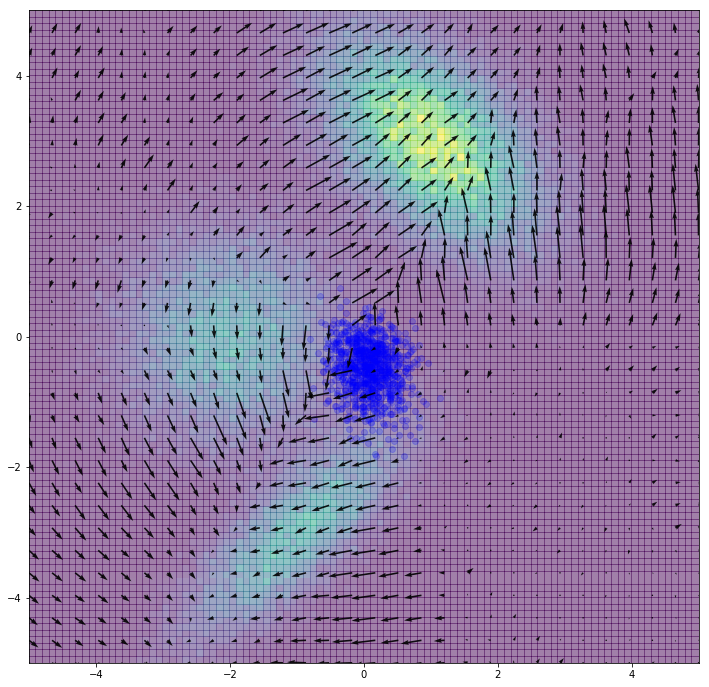

In [10]:
plt.rcParams['figure.figsize'] = (12, 12)
vis_data(data)
vis_g()
vis_d()

**Legend**:
- Blue dots are generated samples. 
- Colored histogram at the back shows density of real data. 
- And with arrows we show gradients of the discriminator -- they are the directions that discriminator pushes generator's samples. 

In [11]:
import torch.autograd as autograd

LAMBDA = 1
def calc_gradient_penalty(real_data, fake_data):
    """
       This function evaluates discriminator's gradient at random points 
       
       The points are composed as a random convex combination of real and fake data
    """
    
    alpha = torch.rand(real_data.shape[0], 1)
    alpha = alpha.expand(real_data.shape[0], real_data.shape[1])

    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).detach()
    interpolates.requires_grad = True    
    
    disc_interpolates = discriminator(interpolates)
    
    # This function evaluate gradient and it is backpropable, so we can get gradient of gradient with .backward()
    gradients = autograd.grad(outputs=disc_interpolates, 
                              inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    
    # Compute norm of the gradient
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

# Train the model

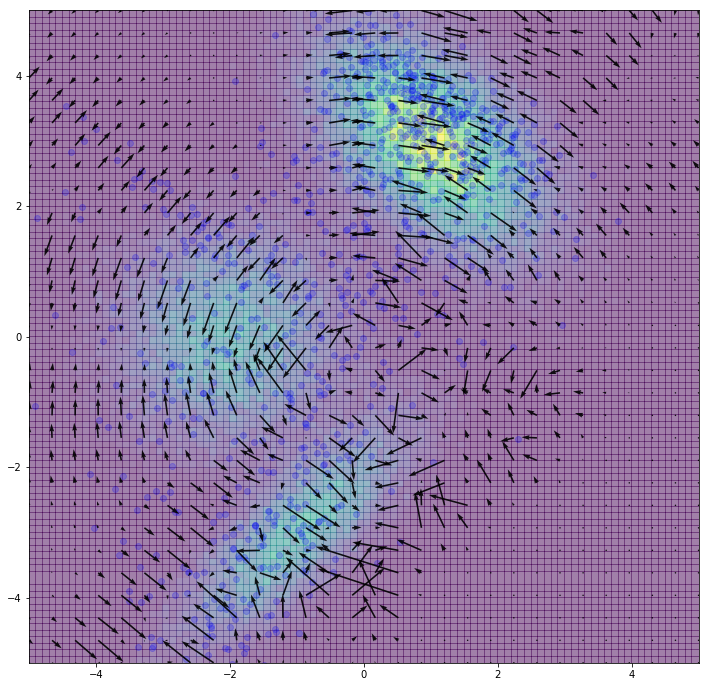

Task 4; Iteration 1562


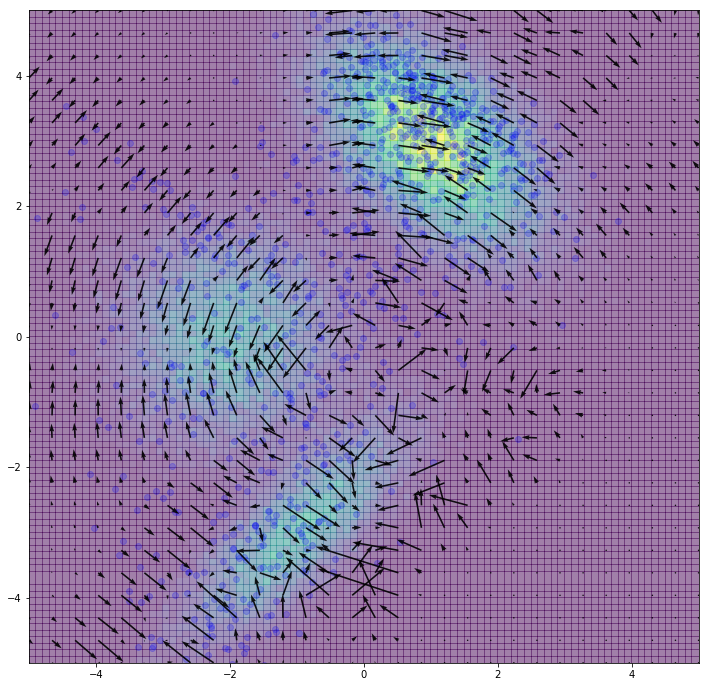

In [12]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 1, 1

try:
    for it, real_data in enumerate(iterate_minibatches(data, batch_size)):

        # Optimize D
        for _ in range(k_d):
            d_optimizer.zero_grad()
            
            # Sample noise
            noise = torch.Tensor(sample_noise(real_data.shape[0]))

            # Do an update
            real_data = torch.Tensor(real_data)
            fake_data = generator(noise)
            loss = d_loss(discriminator(fake_data), discriminator(real_data))            
            loss.backward()
            
            # IMPLEMENT HERE GP FOR TASK 4
            if TASK == 4:
                gp_loss = calc_gradient_penalty(real_data, fake_data)
                print(gp_loss)
                gp_loss.backward()
                
            d_optimizer.step()

        # Optimize G
        for _ in range(k_g):
            g_optimizer.zero_grad()
            
            # Sample noise
            noise = torch.Tensor(sample_noise(real_data.shape[0]))

            # Do an update
            fake_data = generator(noise)
            loss = g_loss(discriminator(fake_data))
            loss.backward()
            
            g_optimizer.step()

        # Visualize
        if it % 2 == 0:
            plt.clf()
            vis_data(data); vis_g(); vis_d()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print(f"Task {TASK}; Iteration {it}")
        
except KeyboardInterrupt:
    pass

# Describe your findings here

Difficult to find normal parameters